# 04 – XGBoost Model Training and Evaluation

Notebook para entrenar, evaluar y validar el modelo XGBoost sobre `Und_2a_percentage`

El objetivo es dejar un artefacto (`.pkl`) listo para consumo desde una app web.


In [1]:
from pathlib import Path
import sys

cwd = Path().resolve()
PROJECT_ROOT = None

for parent in [cwd, *cwd.parents]:
    if (parent / "src").is_dir():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró carpeta 'src' en la jerarquía.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config.settings import (
    PROJECT_ROOT as CFG_PROJECT_ROOT,
    TARGET_COL,
    MODELS_DIR,
    REPORTS_DIR,
)

print("PROJECT_ROOT:", CFG_PROJECT_ROOT)
print("MODELS_DIR  :", MODELS_DIR)
print("REPORTS_DIR :", REPORTS_DIR)


PROJECT_ROOT: D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src
MODELS_DIR  : D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src\data\models
REPORTS_DIR : D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src\reports


## Imports y utilidades del pipeline

Usamos el pipeline modular (`src/`) 

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.load_data import load_clean_dataset
from src.features.build_features import temporal_train_test_split
from src.models.train_xgb import train_xgb_pipeline 
from src.models.inference import predict_batch
from src.models.metrics import regression_metrics  # si creaste este helper

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid")


## Entrenamiento del modelo XGBoost con pipeline 

Entrenamos el modelo usando `train_xgb_pipeline()`, que encapsula:
- carga del dataset limpio,
- split temporal,
- filtrado de outliers en la variable objetivo,
- preprocesamiento (scaling + one-hot),
- ajuste del XGBoost,
- cálculo y guardado de métricas,
- guardado del modelo en `data/models/`.


In [4]:
train_info = train_xgb_pipeline()

train_info


{'model_path': WindowsPath('D:/Users/dhcertug/OneDrive - Crystal S.A.S/Documentos/HOME/00_PERSONAL/02_CURSOS/PROYECTO/Proyecto_analisis_intermedio_udea/src/data/models/modelo_xgb_und2a.pkl'),
 'metrics_path': WindowsPath('D:/Users/dhcertug/OneDrive - Crystal S.A.S/Documentos/HOME/00_PERSONAL/02_CURSOS/PROYECTO/Proyecto_analisis_intermedio_udea/src/reports/metrics_xgb_und2a.json'),
 'metrics': {'MAE': 0.0003843965931795489,
  'RMSE': 0.0012320913800985395,
  'R2': 0.9999856345696319}}

## Lectura de métricas guardadas

Validamos que las métricas persistidas en `reports/metrics_xgb_und2a.json`
coinciden con lo esperado. Para uso desde informes y dashboards.


In [5]:
metrics_path = train_info["metrics_path"]

with open(metrics_path, "r", encoding="utf-8") as f:
    metrics_json = json.load(f)

metrics_json


{'MAE': 0.0003843965931795489,
 'RMSE': 0.0012320913800985395,
 'R2': 0.9999856345696319}

## Validación del modelo guardado (.pkl) sobre un conjunto de test

Recalculamos el split temporal y evaluamos el modelo _ya cargado desde disco_
para asegurarnos de que el artefacto serializado reproduce las métricas.


In [6]:
# 1) Cargar dataset limpio
df = load_clean_dataset()

# 2) Split temporal consistente con el pipeline
X_train, X_test, y_train, y_test = temporal_train_test_split(df)

# 3) Usar el modelo guardado vía `predict_batch`
y_pred = predict_batch(X_test)

# 4) Métricas sobre test
metrics_eval = regression_metrics(y_test, y_pred)
metrics_eval


{'MAE': 0.0003843965931795489,
 'RMSE': 0.0012320913800985395,
 'R2': 0.9999856345696319}

## Curva de predicción vs. valores reales

Inspección visual rápida del ajuste del modelo XGBoost.


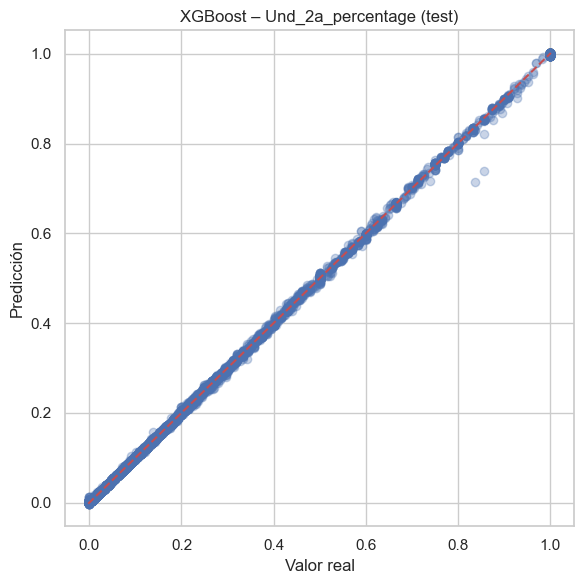

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("XGBoost – Und_2a_percentage (test)")
plt.tight_layout()
plt.show()


## Exportar predicciones para su uso en informes o en una app web

Guardamos un archivo con `y_true` y `y_pred` para comparaciones posteriores.


In [8]:
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
preds_path = REPORTS_DIR / "xgb_predictions_test.csv"

df_preds = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred.values,
})

df_preds.to_csv(preds_path, index=False)
preds_path


WindowsPath('D:/Users/dhcertug/OneDrive - Crystal S.A.S/Documentos/HOME/00_PERSONAL/02_CURSOS/PROYECTO/Proyecto_analisis_intermedio_udea/src/reports/xgb_predictions_test.csv')

## Resumen: artefactos listos para consumo

- Modelo entrenado: `data/models/modelo_xgb_und2a.pkl`
- Métricas: `reports/metrics_xgb_und2a.json`
- Predicciones en test: `reports/xgb_predictions_test.csv`
